In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#!{sys.executable} -m pip install bayesian_optimization
from bayes_opt import BayesianOptimization

# SETTINGS
seed = 124
np.random.seed(seed)
np.set_printoptions(precision=14)

test_size = 0.1

In [3]:
def get_data():

    ## train & test paths
    data_dir = "./data/"

    ### csv w/ layout: "y,x1,x2,x3,x4,x5"
    train_features_file = data_dir+"train_features.csv"
    train_labels_file = data_dir+"train_labels.csv"
    test_features_file = data_dir+"test_features.csv"
    
    data_type = np.double # np dtype object for values in X and Y

    train_features = pd.read_csv(train_features_file)
    train_labels = pd.read_csv(train_labels_file)
    test_features = pd.read_csv(test_features_file)

    return train_features, train_labels, test_features

In [4]:
train_features, train_labels, test_features = get_data()

In [5]:
print(train_features.head())
print(train_features.columns)
train_features.info()

   pid  Time   Age  EtCO2  PTT   BUN  Lactate  Temp  Hgb  HCO3  ...  \
0    1     3  34.0    NaN  NaN  12.0      NaN  36.0  8.7  24.0  ...   
1    1     4  34.0    NaN  NaN   NaN      NaN  36.0  NaN   NaN  ...   
2    1     5  34.0    NaN  NaN   NaN      NaN  36.0  NaN   NaN  ...   
3    1     6  34.0    NaN  NaN   NaN      NaN  37.0  NaN   NaN  ...   
4    1     7  34.0    NaN  NaN   NaN      NaN   NaN  NaN   NaN  ...   

   Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
0           NaN  100.0               NaN     114.0  24.6       94.0   
1           NaN  100.0               NaN       NaN   NaN       99.0   
2           NaN  100.0               NaN       NaN   NaN       92.0   
3           NaN  100.0               NaN       NaN   NaN       88.0   
4           NaN  100.0               NaN       NaN  22.4       81.0   

   Bilirubin_total  TroponinI   ABPs    pH  
0              NaN        NaN  142.0  7.33  
1              NaN        NaN  125.0  7.33  
2          

In [6]:
# means = train_features.mean()
train_features.fillna(0, inplace=True)
train_features.head()

grouped_pid = train_features.groupby("pid")
train_feature_labels = train_features.columns

# column_names = [f"{label}_{i}" for i in range(12) for label in train_feature_labels]


In [7]:
# from tqdm import tqdm
# preprocessed_train_features_arr = []
# for pid, group in tqdm(grouped_pid):
#     # print(group)

#     row_arr = []
#     min_time = group['Time'].min()
#     for i, row in group.iterrows():
#         # row = row.to_frame()
#         age = row["Age"]
#         time = int(row["Time"] - min_time)
#         row = row.drop(["pid", "Age", "Time"])
#         row = row.add_suffix(f"_{str(time)}")
#         row_arr.append(row)
#     # print(df)

#     pid_age_df = pd.DataFrame({"pid": pid, "Age": age}, index=[0]).T
    
#     # column_names = [f"{label}_{i}" for i in range(12) for label in pid_age_df.columns ].append("pid", "Age")
#     row_arr.append(pid_age_df)
#     final_row = pd.concat(row_arr)
#     # print("row_arr", final_row, "end_row_arr", len(row_arr))

#     preprocessed_train_features_arr.append(final_row.T)
    


# preprocessed_train_features = pd.concat(preprocessed_train_features_arr, axis=0, ignore_index=True)

# preprocessed_train_features.head()

In [8]:
# preprocessed_train_features.to_csv("./data/preprocessed_train_features.csv")

In [9]:
preprocessed_train_features = pd.read_csv("./data/preprocessed_train_features.csv")

In [10]:
# 1. Subtask
labels_to_predict = ["LABEL_BaseExcess", "LABEL_Fibrinogen", "LABEL_AST", "LABEL_Alkalinephos", "LABEL_Bilirubin_total", "LABEL_Lactate", "LABEL_TroponinI", "LABEL_SaO2", "LABEL_Bilirubin_direct", "LABEL_EtCO2"]
y1 = train_labels[labels_to_predict]
print(y1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18995 entries, 0 to 18994
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LABEL_BaseExcess        18995 non-null  float64
 1   LABEL_Fibrinogen        18995 non-null  float64
 2   LABEL_AST               18995 non-null  float64
 3   LABEL_Alkalinephos      18995 non-null  float64
 4   LABEL_Bilirubin_total   18995 non-null  float64
 5   LABEL_Lactate           18995 non-null  float64
 6   LABEL_TroponinI         18995 non-null  float64
 7   LABEL_SaO2              18995 non-null  float64
 8   LABEL_Bilirubin_direct  18995 non-null  float64
 9   LABEL_EtCO2             18995 non-null  float64
dtypes: float64(10)
memory usage: 1.4 MB
None


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_features, y1, test_size=test_size, random_state=seed)
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [12]:
X_train, y_train

(       Unnamed: 0  EtCO2_0  PTT_0  BUN_0  Lactate_0  Temp_0  Hgb_0  HCO3_0  \
 1055         1055      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 7611         7611      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 10976       10976      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 10171       10171      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 94             94      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 ...           ...      ...    ...    ...        ...     ...    ...     ...   
 681           681      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 9154         9154      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 14353       14353      0.0    0.0    0.0        0.0    38.0    0.0     0.0   
 4764         4764      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 4558         4558      0.0    0.0    0.0        0.0     0.0    0.0     0.0   
 
        BaseExcess_0  RRate_0  ...  Bilirubin_dire

LABEL_BaseExcess
['BaseExcess_0', 'BaseExcess_1', 'BaseExcess_2', 'BaseExcess_3', 'BaseExcess_4', 'BaseExcess_5', 'BaseExcess_6', 'BaseExcess_7', 'BaseExcess_8', 'BaseExcess_9', 'BaseExcess_10', 'BaseExcess_11']
[[0.50505659798196 0.49494340201804]
 [0.50317425109987 0.49682574890013]
 [0.49123321930408 0.50876678069592]
 ...
 [0.50543698893209 0.49456301106791]
 [0.48830587858278 0.51169412141722]
 [0.4957391228272  0.5042608771728 ]]
roc auc score: 0.49196593457327525


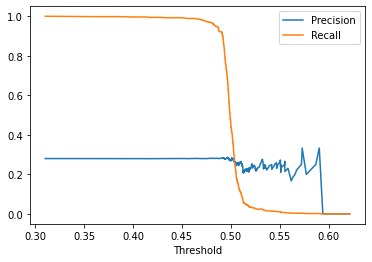

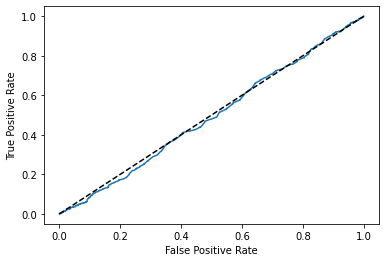

LABEL_Fibrinogen
['Fibrinogen_0', 'Fibrinogen_1', 'Fibrinogen_2', 'Fibrinogen_3', 'Fibrinogen_4', 'Fibrinogen_5', 'Fibrinogen_6', 'Fibrinogen_7', 'Fibrinogen_8', 'Fibrinogen_9', 'Fibrinogen_10', 'Fibrinogen_11']
[[0.50068274406322 0.49931725593678]
 [0.50095949268026 0.49904050731974]
 [0.5008672431982  0.4991327568018 ]
 ...
 [0.50117474120686 0.49882525879314]
 [0.49954499720118 0.50045500279882]
 [0.50025224544541 0.49974775455459]]
roc auc score: 0.48470638255302123


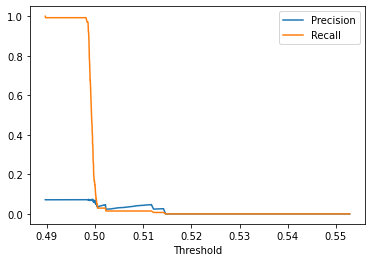

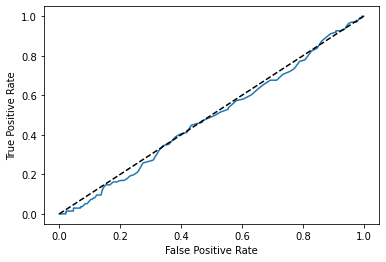

LABEL_AST
['AST_0', 'AST_1', 'AST_2', 'AST_3', 'AST_4', 'AST_5', 'AST_6', 'AST_7', 'AST_8', 'AST_9', 'AST_10', 'AST_11']
[[0.50012760013671 0.49987239986329]
 [0.49987017155484 0.50012982844516]
 [0.49995598108122 0.50004401891878]
 ...
 [0.49966994936509 0.50033005063491]
 [0.50118591544227 0.49881408455773]
 [0.5005280444127  0.4994719555873 ]]
roc auc score: 0.47810461956521744


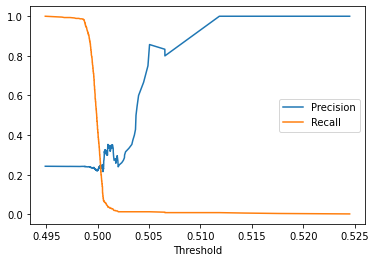

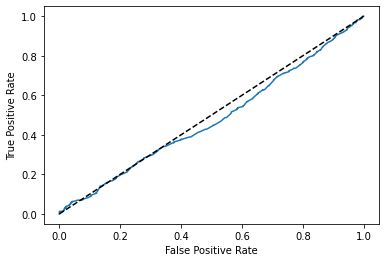

LABEL_Alkalinephos
['Alkalinephos_0', 'Alkalinephos_1', 'Alkalinephos_2', 'Alkalinephos_3', 'Alkalinephos_4', 'Alkalinephos_5', 'Alkalinephos_6', 'Alkalinephos_7', 'Alkalinephos_8', 'Alkalinephos_9', 'Alkalinephos_10', 'Alkalinephos_11']
[[0.49946231437759 0.50053768562241]
 [0.49928997534718 0.50071002465282]
 [0.49934742167393 0.50065257832607]
 ...
 [0.49915593399363 0.50084406600637]
 [0.50017082017647 0.49982917982353]
 [0.49973039755265 0.50026960244735]]
roc auc score: 0.48439004565919225


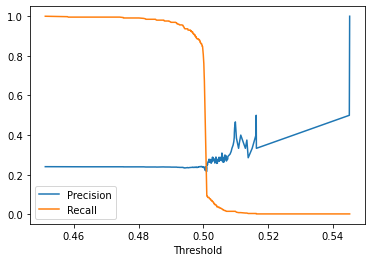

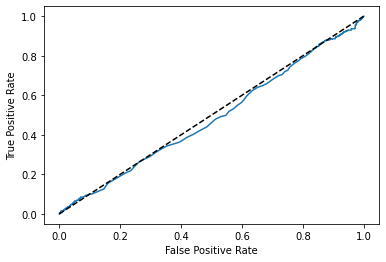

LABEL_Bilirubin_total
['Bilirubin_total_0', 'Bilirubin_total_1', 'Bilirubin_total_2', 'Bilirubin_total_3', 'Bilirubin_total_4', 'Bilirubin_total_5', 'Bilirubin_total_6', 'Bilirubin_total_7', 'Bilirubin_total_8', 'Bilirubin_total_9', 'Bilirubin_total_10', 'Bilirubin_total_11']
[[0.4999976500804  0.5000023499196 ]
 [0.50011927701091 0.49988072298909]
 [0.5000787347016  0.4999212652984 ]
 ...
 [0.50021387572562 0.49978612427438]
 [0.4994976284147  0.5005023715853 ]
 [0.49980845263878 0.50019154736122]]
roc auc score: 0.5107737592855304


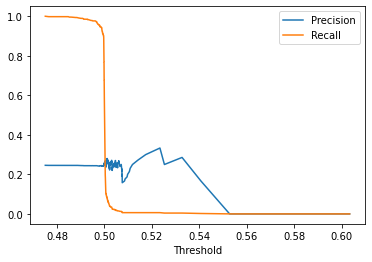

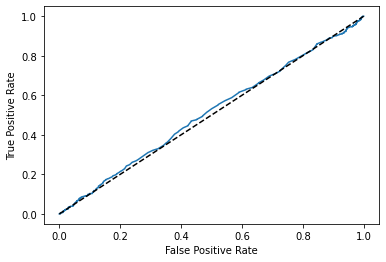

LABEL_Lactate
['Lactate_0', 'Lactate_1', 'Lactate_2', 'Lactate_3', 'Lactate_4', 'Lactate_5', 'Lactate_6', 'Lactate_7', 'Lactate_8', 'Lactate_9', 'Lactate_10', 'Lactate_11']
[[0.52390748736224 0.47609251263776]
 [0.49795915642263 0.50204084357737]
 [0.4983135683602  0.5016864316398 ]
 ...
 [0.4971322038258  0.5028677961742 ]
 [0.50339348508402 0.49660651491598]
 [0.50067634072701 0.49932365927299]]
roc auc score: 0.4851474699171302


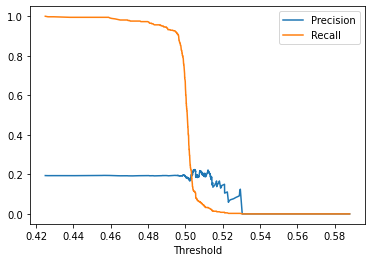

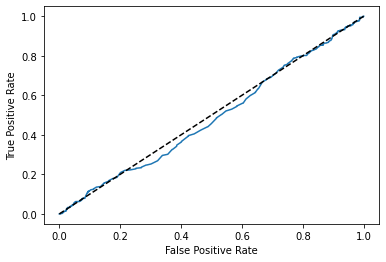

LABEL_TroponinI
['TroponinI_0', 'TroponinI_1', 'TroponinI_2', 'TroponinI_3', 'TroponinI_4', 'TroponinI_5', 'TroponinI_6', 'TroponinI_7', 'TroponinI_8', 'TroponinI_9', 'TroponinI_10', 'TroponinI_11']
[[0.50000181343142 0.49999818656858]
 [0.5001457089304  0.4998542910696 ]
 [0.50006431562857 0.49993568437143]
 ...
 [0.50031944817403 0.49968055182597]
 [0.49896724696678 0.50103275303322]
 [0.49955405057004 0.50044594942996]]
roc auc score: 0.5128493059902066


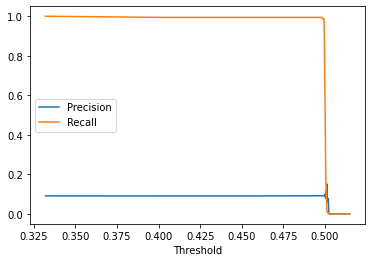

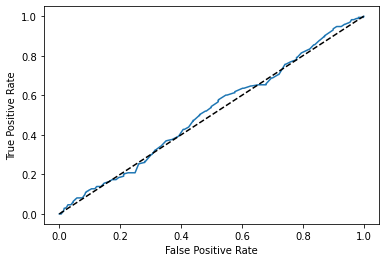

LABEL_SaO2
['SaO2_0', 'SaO2_1', 'SaO2_2', 'SaO2_3', 'SaO2_4', 'SaO2_5', 'SaO2_6', 'SaO2_7', 'SaO2_8', 'SaO2_9', 'SaO2_10', 'SaO2_11']
[[0.50318773721094 0.49681226278906]
 [0.50490676706569 0.49509323293431]
 [0.48211309104648 0.51788690895352]
 ...
 [0.50624371216793 0.49375628783207]
 [0.49612026549506 0.50387973450494]
 [0.50051355592827 0.49948644407173]]
roc auc score: 0.48431332516673475


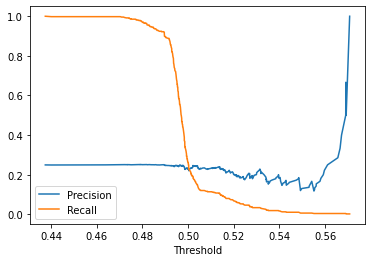

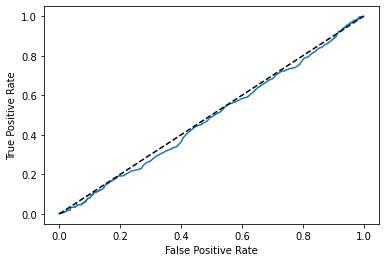

LABEL_Bilirubin_direct
['Bilirubin_direct_0', 'Bilirubin_direct_1', 'Bilirubin_direct_2', 'Bilirubin_direct_3', 'Bilirubin_direct_4', 'Bilirubin_direct_5', 'Bilirubin_direct_6', 'Bilirubin_direct_7', 'Bilirubin_direct_8', 'Bilirubin_direct_9', 'Bilirubin_direct_10', 'Bilirubin_direct_11']
[[0.49998088132491 0.50001911867509]
 [0.49927718548652 0.50072281451348]
 [0.49951175058549 0.50048824941451]
 ...
 [0.498729868338   0.501270131662  ]
 [0.50287382352831 0.49712617647169]
 [0.50107551842018 0.49892448157982]]
roc auc score: 0.4768957871396895


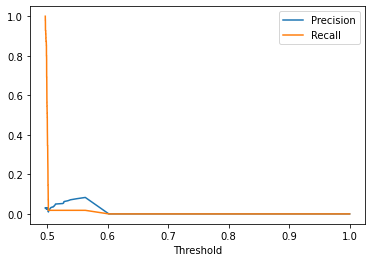

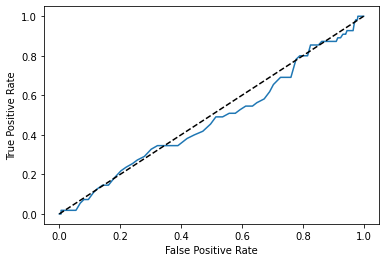

LABEL_EtCO2
['EtCO2_0', 'EtCO2_1', 'EtCO2_2', 'EtCO2_3', 'EtCO2_4', 'EtCO2_5', 'EtCO2_6', 'EtCO2_7', 'EtCO2_8', 'EtCO2_9', 'EtCO2_10', 'EtCO2_11']
[[0.50059759551653 0.49940240448347]
 [0.50742095862641 0.49257904137359]
 [0.50514668588627 0.49485331411373]
 ...
 [0.51272623823632 0.48727376176368]
 [0.47257131640382 0.52742868359618]
 [0.48998396819147 0.51001603180853]]
roc auc score: 0.5073235144743524


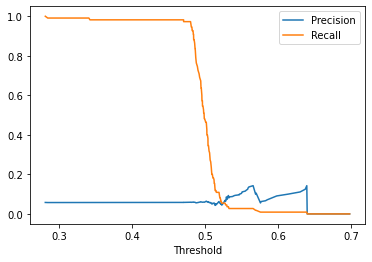

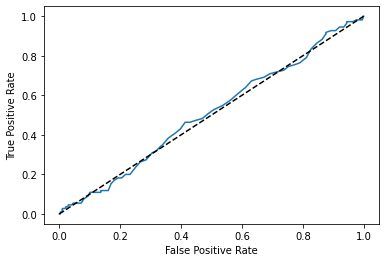

In [13]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

for label in labels_to_predict:
    print(label)
    clf = LogisticRegressionCV(class_weight='balanced', n_jobs=6, cv=10, max_iter=200, scoring="roc_auc", random_state=seed)
    # clf = SVC(probability=True, class_weight='balanced')
    
    wanted_features = [l for l in X_train.columns if "_".join(label.split("_")[1:]) in l]
    print(wanted_features)
    wanted_features.append("Age")
    X_train_filtered = X_train[wanted_features]
    X_test_filtered = X_test[wanted_features]
    
    scaler = preprocessing.StandardScaler().fit(X_train_filtered)    
    X_train_scaled = scaler.transform(X_train_filtered)
    X_test_scaled = scaler.transform(X_test_filtered)
    clf.fit(X_train_scaled, y_train[label])

    pred = clf.predict_proba(X_test_scaled)

    print(pred)
    score = roc_auc_score(y_test[label], pred[:, 1])
    print(f"roc auc score: {score}")


    precisions, recalls, thresholds = precision_recall_curve(y_test[label], pred[:, 1])

    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

    # mean_squared_error(y_test["LABEL_BaseExcess"], pred[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test[label], pred[:, 1])
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [14]:
def save_submission(submission):

    ## prediction submission paths
    sub_dir = "./submission/"
    sub_file = "submission.csv"
    sub_path = sub_dir + sub_file


    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)


    ## submission csv header
    sub_header = ""
    sub_format = "%.13f"
    np.savetxt(sub_path,
               submission,
               fmt = sub_format,
               delimiter = ',',
               header = sub_header,
               comments = '')